In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import csv
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import io
from urllib.request import urlopen, Request
from PIL import Image

In [23]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

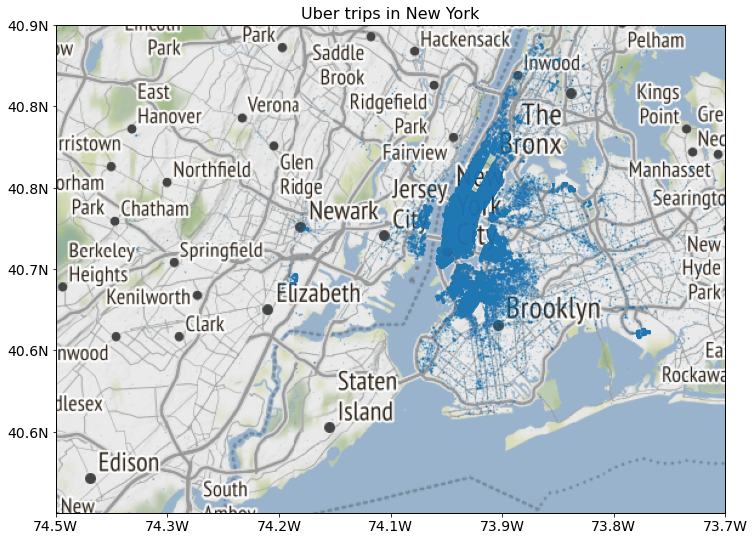

In [44]:
#######################################
# Formatting the Cartopy plot
#######################################
#
cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.Stamen('terrain') # spoofed, downloaded street map

fig = plt.figure(figsize=(12,9)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
ax1.set_title('Uber trips in New York',fontsize=16)
# extent = [-124.7844079,-66.9513812, 24.7433195, 49.3457868] # Contiguous US bounds
#extent = [-74.257159,-73.699215,40.495992,40.915568] # NYC bounds
extent = [-74.45,-73.69,40.49,40.91] # NYC bounds
ax1.set_extent(extent) # set extents
ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
ax1.scatter("Lon","Lat", data=data, s=1, transform=ccrs.PlateCarree(), alpha=.1)

## Chargement des données

In [2]:
data = pd.read_csv("uber-raw-data-apr14.csv")

In [4]:
data.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [11]:
data.shape

(564516, 4)

In [5]:
base = pd.read_csv("base_codes.csv")

In [9]:
base.head(8)

,Base Code,Base Name
0,B02512,Unter
1,B02598,Hinter
2,B02617,Weiter
3,B02682,Schmecken
4,B02764,Danach-NY
5,B02765,Grun
6,B02835,Dreist
7,B02836,Drinnen


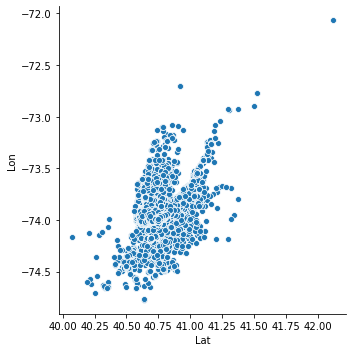

In [20]:
sns.relplot(x='Lat', y='Lon', data=data)

In [29]:
ax1.scatter("Lon","Lat", data=data, s=1, transform=ccrs.PlateCarree(), alpha=.1)